# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install -q segmentation-models-pytorch
!pip install -Uq git+https://github.com/albumentations-team/albumentations
!pip install -q --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 8.9 MB/s eta 0:00:00


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 41.70 MiB/s, done.
Resolving deltas: 100% (3/3), done.


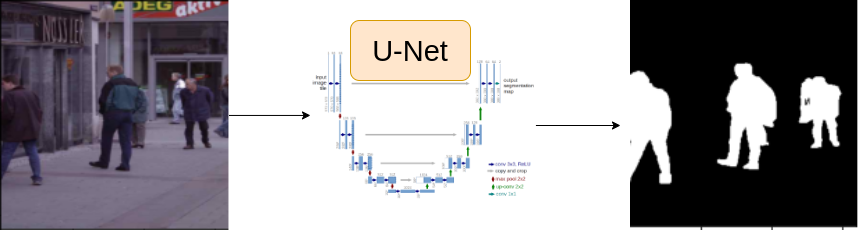

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
df = pd.read_csv('Human-Segmentation-Dataset-master/train.csv')
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [6]:
len(df)

290

In [7]:
row = df.iloc[15]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.

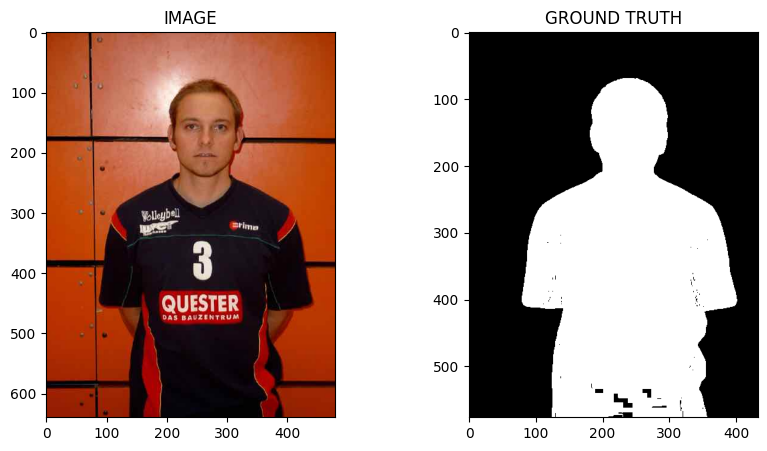

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
df_train, df_val = train_test_split(df, test_size = 0.2, random_state = 42)

In [10]:
len(df_train)

232

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

img_size = 320

In [12]:
def get_train_augs():
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_val_augs():
    return A.Resize(img_size, img_size)

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
    def __init__(self, df, aug_func):
        self.df = df
        self.aug_func = aug_func

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)   # (w, h)
        mask = np.expand_dims(mask, axis = -1)    # (w, h, c)

        if self.aug_func:
            augmented = self.aug_func(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # (w, h, c)  -->  (c, w, h)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.
        mask = torch.round(torch.Tensor(mask) / 255.)

        return image, mask

In [15]:
train_data = SegmentationDataset(df_train, get_train_augs())
val_data = SegmentationDataset(df_val, get_val_augs())

In [16]:
print(f"Size of Train Data : {len(train_data)}")
print(f"Size of Valid Data : {len(val_data)}")

Size of Train Data : 232
Size of Valid Data : 58


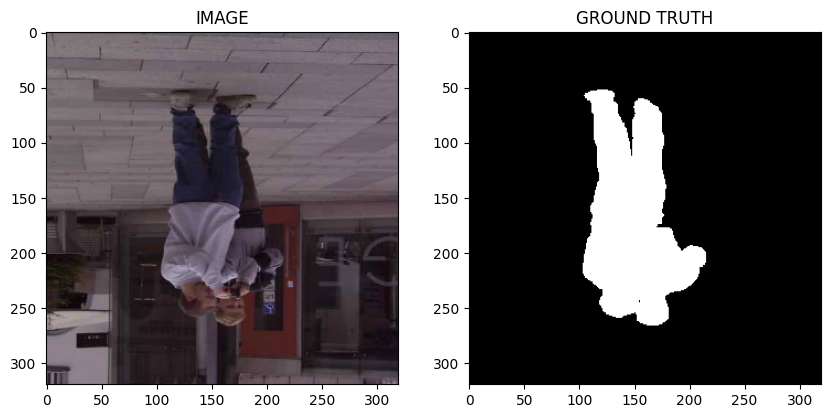

In [17]:
helper.show_image(*train_data[10])

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 16)

In [20]:
print(f'No. of batches in train_loader: {len(train_loader)}')
print(f'No. of batches in val_loader: {len(val_loader)}')

No. of batches in train_loader: 15
No. of batches in val_loader: 4


In [21]:
img, msk = next(iter(train_loader))

print(f'Image shape: {img.shape}')
print(f'Mask shape: {msk.shape}')

Image shape: torch.Size([16, 3, 320, 320])
Mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
class SegmentationModel(nn.Module):
    def __init__(self, encoder_name, encoder_weights, num_classes):
        super().__init__()
        self.arc = smp.Unet(
            encoder_name = encoder_name,
            encoder_weights = encoder_weights,
            in_channels = 3,
            classes = num_classes,
            activation = None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)
        loss = 0
        if masks is not None:
            loss1 = DiceLoss(mode = 'binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1+loss2

        return logits

In [25]:
model = SegmentationModel('timm-efficientnet-b0', 'imagenet', 1)
model.to(device);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 142MB/s]


# Task 7 : Create Train and Validation Function

In [26]:
from tqdm import tqdm

In [27]:
def train(data_loader, model, optimizer):

    model.train()

    total_loss = 0

    for images, masks in tqdm(data_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [28]:
def eval(data_loader, model):

    model.eval()

    total_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)

            logits, loss = model(images, masks)
            total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [30]:
best_val_loss = np.Inf

for i in range(25):
    train_loss = train(train_loader, model, optimizer)
    val_loss = eval(val_loader, model)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch: {i+1} ---- Train_Loss: {train_loss:.4f} ---- Val_Loss: {val_loss:.4f}\n')

 93%|█████████▎| 14/15 [00:08<00:00,  2.35it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch: 1 ---- Train_Loss: 1.3844 ---- Val_Loss: 1.2094



100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch: 2 ---- Train_Loss: 1.2029 ---- Val_Loss: 0.9547



100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch: 3 ---- Train_Loss: 1.0344 ---- Val_Loss: 0.8696



100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Epoch: 4 ---- Train_Loss: 0.9132 ---- Val_Loss: 0.7859



100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch: 5 ---- Train_Loss: 0.8169 ---- Val_Loss: 0.7389



100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch: 6 ---- Train_Loss: 0.7438 ---- Val_Loss: 0.6878



100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Epoch: 7 ---- Train_Loss: 0.6935 ---- Val_Loss: 0.6369



100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch: 8 ---- Train_Loss: 0.6292 ---- Val_Loss: 0.6062



100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Epoch: 9 ---- Train_Loss: 0.6067 ---- Val_Loss: 0.5725



100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch: 10 ---- Train_Loss: 0.5667 ---- Val_Loss: 0.5372



100%|██████████| 4/4 [00:00<00:00,  6.16it/s]


Epoch: 11 ---- Train_Loss: 0.5276 ---- Val_Loss: 0.5186



100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch: 12 ---- Train_Loss: 0.5087 ---- Val_Loss: 0.5003



100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch: 13 ---- Train_Loss: 0.4780 ---- Val_Loss: 0.4809



100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch: 14 ---- Train_Loss: 0.4580 ---- Val_Loss: 0.4541



100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch: 15 ---- Train_Loss: 0.4289 ---- Val_Loss: 0.4397



100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch: 16 ---- Train_Loss: 0.4214 ---- Val_Loss: 0.4187



100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch: 17 ---- Train_Loss: 0.3873 ---- Val_Loss: 0.4038



100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Epoch: 18 ---- Train_Loss: 0.3786 ---- Val_Loss: 0.3931



100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Epoch: 19 ---- Train_Loss: 0.3637 ---- Val_Loss: 0.3830



100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch: 20 ---- Train_Loss: 0.3470 ---- Val_Loss: 0.3717



100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch: 21 ---- Train_Loss: 0.3391 ---- Val_Loss: 0.3518



100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Epoch: 22 ---- Train_Loss: 0.3106 ---- Val_Loss: 0.3394



100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch: 23 ---- Train_Loss: 0.3007 ---- Val_Loss: 0.3301



100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch: 24 ---- Train_Loss: 0.2951 ---- Val_Loss: 0.3236



100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch: 25 ---- Train_Loss: 0.2761 ---- Val_Loss: 0.3102



# Task 9 : Inference

In [31]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [33]:
image, mask = val_data[12]

logits_mask = model(image.to(device).unsqueeze(0))  # (C, H, W) -->  (1, C, H, W)
pred_mask = (torch.sigmoid(logits_mask) > 0.5) * 1.

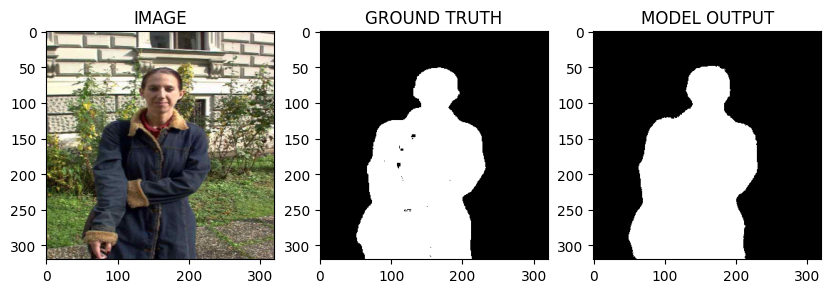

In [34]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya